# Imports

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.experimental import enable_halving_search_cv # needed for HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV

# Loading Data

We load data here and perform some preprocessing such as dropping title column and encoding the ESRB_Rating column. The data is then split into train_X and train_Y

In [26]:
train_df = pd.read_csv("cleaned_data.csv", index_col=0)
test_df = pd.read_csv("test_esrb.csv")

original_train_df = train_df.copy()
original_test_df = test_df.copy()

train_df = train_df.drop(columns=['title'])
test_df = test_df.drop(columns=['title'])

ENCODINGS = {"E": 0, "ET": 1, "T": 2, "M": 3}
ENCODING_LABELS = list(ENCODINGS.keys())

train_df.esrb_rating = train_df.esrb_rating.replace(ENCODINGS)
test_df.esrb_rating = test_df.esrb_rating.replace(ENCODINGS)

train_X = train_df.drop(['esrb_rating'], axis=1)
train_Y = train_df['esrb_rating']

test_X = test_df.drop(['esrb_rating'], axis=1)
test_Y = test_df['esrb_rating']

In [37]:
print(f"Train_X shape: {train_X.shape}\tTrain_Y shape: {train_Y.shape}")
print(f"Test_X shape:  {test_X.shape}\tTest_Y shape:  {test_Y.shape}")

Train_X shape: (1889, 32)	Train_Y shape: (1889,)
Test_X shape:  (500, 32)	Test_Y shape:  (500,)


# Visualizing Test Data distribution

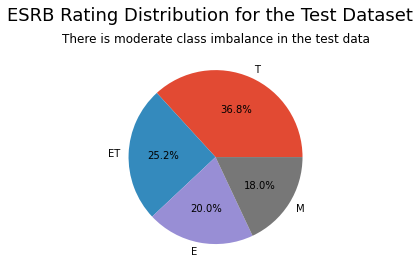

In [35]:
chart_data = original_test_df[["esrb_rating"]].value_counts()
chart_labels = []

for i in list(chart_data.index):
    chart_labels.append(i[0])

plt.pie(chart_data, labels=list(chart_labels), autopct='%1.1f%%')
plt.title("There is moderate class imbalance in the test data", fontsize=12)
plt.suptitle("ESRB Rating Distribution for the Test Dataset",
             fontsize=18, y=1.025)
plt.show()

# Finding Best Parameters for SVM

We define a range of values for different parameters for the SVM model, such as regularization parameter C = np.linspace(0.1, 100, 10). We then use HalvingGridSearchCV to exhaustively find the best parameters from these ranges. 

In [40]:
C = np.linspace(0.1, 100, 10)
degree = [2, 3, 4, 5, 6]
gamma = list(np.round(np.linspace(0.1, 10, 10), 3))
gamma.append('scale')
gamma.append('auto')
kernel = ['poly', 'rbf', 'sigmoid']

param_grid = {'C': C, 'degree': degree, 'gamma': gamma, 'kernel': kernel}
print(param_grid)

{'C': array([  0.1,  11.2,  22.3,  33.4,  44.5,  55.6,  66.7,  77.8,  88.9,
       100. ]), 'degree': [2, 3, 4, 5, 6], 'gamma': [0.1, 1.2, 2.3, 3.4, 4.5, 5.6, 6.7, 7.8, 8.9, 10.0, 'scale', 'auto'], 'kernel': ['poly', 'rbf', 'sigmoid']}


In [30]:
svm_model = HalvingGridSearchCV(
    SVC(), 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=20,
    refit=True,
)
svm_model.fit(train_X, train_Y)

HalvingGridSearchCV(estimator=SVC(), n_jobs=20,
                    param_grid={'C': array([  0.1,  11.2,  22.3,  33.4,  44.5,  55.6,  66.7,  77.8,  88.9,
       100. ]),
                                'degree': [2, 3, 4, 5],
                                'gamma': [0.1, 1.2000000000000002,
                                          2.3000000000000003,
                                          3.4000000000000004, 4.5, 5.6, 6.7,
                                          7.800000000000001, 8.9, 10.0, 'scale',
                                          'auto'],
                                'kernel': ['poly', 'rbf', 'sigmoid']},
                    scoring='accuracy')

The best parameters have been found:

In [31]:
print("Best parameters:", svm_model.best_params_)
best_svm_model = svm_model.best_estimator_

Best parameters: {'C': 22.300000000000004, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}


# Testing Pipeline

Precision, Recall, Accuracy and confusion matrix can all be seen here. As evident by the results, the model performs very well

In [33]:
preds = best_svm_model.predict(test_X)
print(classification_report(test_Y, preds, target_names=ENCODING_LABELS))

cfm = confusion_matrix(test_Y, preds)

plt.figure(figsize=(10, 10))
sns.heatmap(pd.DataFrame(cfm, ENCODING_LABELS, ENCODING_LABELS),
            annot=True, fmt='d', square=True)


              precision    recall  f1-score   support

           E       0.95      0.95      0.95       100
          ET       0.84      0.87      0.85       126
           T       0.82      0.86      0.84       184
           M       0.91      0.76      0.82        90

    accuracy                           0.86       500
   macro avg       0.88      0.86      0.87       500
weighted avg       0.86      0.86      0.86       500

